# Shuttlt bus data analysis

### not calculate distance and predict by original data 

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math
import plotly
from datetime import tzinfo, timedelta, datetime

### load file

In [4]:
#get the stop segment
csv_stop = pd.read_csv("./../data/iot.stops.csv",sep = '\t',header = 0)
csv_route = pd.read_csv("./../data/iot.routes.csv",sep = '\t',header = 0)

#for calculate the distances between 2 stops 
csv_record = pd.read_csv("./../data/iot.locations.csv",sep = '\t',header = 0)

## 1. data display

### @functions

In [70]:
#坐标系转平面坐标
def mct2x(lat):
    x = lat/ 20037508.3427892 * 180 
    return x
def mct2y(lon):
    result = []
    for i in lon:
        y = i/ 20037508.3427892 * 180 
        y = 180 / math.pi * (2 * math.atan(math.exp(y * math.pi / 180)) - math.pi / 2) 
        result.append(y)
    return result

# record should order by longitude first
def core_field_extra(stops,records):
    start = datetime.now()
    
    df =pd.DataFrame(columns = ['latitude','longitude','routeNumber','updated','plannedArrivalTime','device','segment'])
    latitude = '' 
    longitude = ''
    routeNumber = route_stops.iloc[0].routeNumber 
    updated = ''
    plannedArrivalTime = ''
    device = ''
    segment = ''
    
    bus_tracker = 0 #// for bus stop change use
    for raw in records.itertuples():
        if(bus_tracker < len(stops)):
            flag = raw.latitude < stops.iloc[[bus_tracker]].latitude
            if(flag.any()):
                    continue
            elif(bus_tracker+1 < len(stops)):
                if((raw.latitude >= stops.iloc[[bus_tracker]].latitude).any() & (raw.latitude <= stops.iloc[[bus_tracker+1]].latitude).any()):
                    latitude = raw.latitude
                    longitude = raw.longitude
                    updated = raw.updated
                    plannedArrivalTime = stops.iloc[bus_tracker+1].plannedArrivalTime
                    device = raw.device
                    segment = stops.iloc[bus_tracker,10] + '-' + stops.iloc[bus_tracker+1,10]
                    
                    df = df.append({'latitude':latitude,'longitude':longitude,'routeNumber':routeNumber,
                                   'updated':updated,'plannedArrivalTime':plannedArrivalTime,'device':device,
                                   'segment':segment},ignore_index=True)
                else:
                    latitude = '' 
                    longitude = ''
                    updated = ''
                    plannedArrivalTime = ''
                    device = ''
                    segment = ''
                    bus_tracker= bus_tracker + 1 
#         print('sub_main_Duration:',(datetime.now() - start).total_seconds())
#     print('sub_Duration:',(datetime.now() - start).total_seconds())
    return df
        
def calculate_distance(lat1,lng1,lat2,lng2):
    radlat1= math.radians(lat1)  
    radlat2=math.radians(lat2)  
    a=radlat1-radlat2  
    b=math.radians(lng1)-math.radians(lng2)  
    s=2*math.asin(math.sqrt(math.pow(math.sin(a/2),2)+math.cos(radlat1)*math.cos(radlat2)*math.pow(math.sin(b/2),2)))  
    earth_radius = 6371.393  
    s=s*earth_radius  
    if(s<0):
        return -s*1000
    else:
        return s*1000
 

In [5]:
# link route and stop info together
csv_route_num1 = csv_route[(csv_route.routeNumber ==1) & (csv_route.isGo2Work == True) ]
csv_route_num1 = csv_route_num1.sort_values(["seqNumber"],ascending = True)
csv_route_num1 = csv_route_num1.iloc[:,1:7]

route_stops = csv_route_num1.merge(csv_stop,left_on='stopId',right_on = '_id')

In [6]:
route_stops.head(10)

,busId,isGo2Work,plannedArrivalTime,routeNumber,seqNumber,stopId,_id,isGoToWork,latitude,longitude,stopName,updated
0,5ae8393c3023169da447c2ae,True,7:23,1,1,5ae83320748fb2a67c5f6e54,5ae83320748fb2a67c5f6e54,True,22.249541,113.520559,明珠中,2018-05-01T09:28:00.844Z
1,5ae8393c3023169da447c2ae,True,7:26,1,2,5ae8334c748fb2a67c5f6e55,5ae8334c748fb2a67c5f6e55,True,22.256653,113.519771,翠微,2018-05-01T09:28:44.366Z
2,5ae8393c3023169da447c2ae,True,7:34,1,3,5ae8336c748fb2a67c5f6e56,5ae8336c748fb2a67c5f6e56,True,22.267762,113.536134,仁恒星园,2018-05-01T09:29:16.147Z
3,5ae8393c3023169da447c2ae,True,7:37,1,4,5ae834df567e17937cf407e1,5ae834df567e17937cf407e1,True,22.268722,113.542062,香洲区府,2018-05-01T09:35:27.388Z
4,5ae8393c3023169da447c2ae,True,7:38,1,5,5ae83521567e17937cf407e2,5ae83521567e17937cf407e2,True,22.269261,113.545517,南村,2018-05-01T09:36:33.812Z
5,5ae8393c3023169da447c2ae,True,7:40,1,6,5ae8353d567e17937cf407e3,5ae8353d567e17937cf407e3,True,22.276603,113.557696,兴业中,2018-05-01T09:37:01.373Z
6,5ae8393c3023169da447c2ae,True,8:30,1,7,5af85642ac5680781c7bb90c,5af85642ac5680781c7bb90c,True,22.372631,113.575924,南方软件园,2018-05-13T15:14:10.382Z


In [88]:
#filter 2018-5-30 
csv_record_bus1 = csv_record[(csv_record['bus']== 1.0)
                              & (csv_record['device']!= 'arduino')
                              & (pd.to_datetime(csv_record['updated'],utc = True) > pd.to_datetime('2018/06/24 23:00',utc = True))
                              & (pd.to_datetime(csv_record['updated'],utc = True) < pd.to_datetime('2018/06/25 00:40',utc = True))] # filter all bus1 data

In [90]:
csv_record_bus1 = csv_record_bus1.sort_values(by = 'updated',ascending = True)
bus1_copy = csv_record_bus1.copy()
location = bus1_copy

location.head()

,bus,device,latitude,longitude,updated
33750,1,hcb,22.249672,113.523808,2018-06-24T23:00:00.507Z
33751,1,hcb,22.249672,113.523808,2018-06-24T23:00:02.444Z
33752,1,hcb,22.249672,113.523808,2018-06-24T23:00:04.430Z
33753,1,hcb,22.249672,113.523808,2018-06-24T23:00:06.416Z
33754,1,hcb,22.249672,113.523808,2018-06-24T23:00:08.872Z


In [97]:
csv_record_bus2 = csv_record_bus1[csv_record_bus1['latitude'] < 22.249673]
csv_record_bus2

,bus,device,latitude,longitude,updated
33750,1,hcb,22.249672,113.523808,2018-06-24T23:00:00.507Z
33751,1,hcb,22.249672,113.523808,2018-06-24T23:00:02.444Z
33752,1,hcb,22.249672,113.523808,2018-06-24T23:00:04.430Z
33753,1,hcb,22.249672,113.523808,2018-06-24T23:00:06.416Z
33754,1,hcb,22.249672,113.523808,2018-06-24T23:00:08.872Z
33755,1,hcb,22.249672,113.523808,2018-06-24T23:00:10.444Z
33756,1,hcb,22.249672,113.523808,2018-06-24T23:00:12.407Z
33757,1,hcb,22.249672,113.523808,2018-06-24T23:00:14.481Z
33758,1,hcb,22.249672,113.523808,2018-06-24T23:00:16.721Z
33759,1,hcb,22.249672,113.523808,2018-06-24T23:00:18.429Z


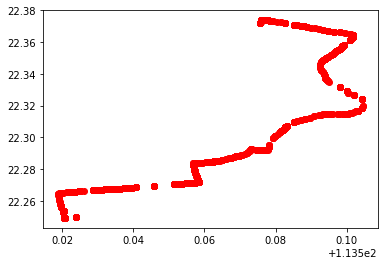

In [77]:
plt.plot(location['longitude'],location['latitude'],'ro')

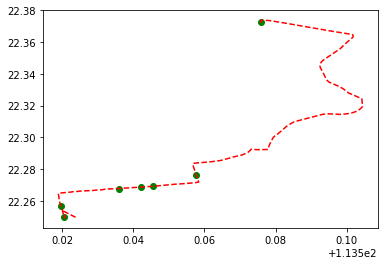

In [78]:
plt.plot(route_stops.longitude,route_stops.latitude, "go",location['longitude'],location['latitude'],'r--')

## 2.data extra

### @functions

In [71]:
# start_date: date time start, string format: yyyy/MM/dd HH:mm, kindly remind start HH:mm should be '23:00'
# stop_date: date time ending, string format: yyyy/MM/dd HH:mm, kindly remind stop HH:mm should be '00:40'
# records

def extra_train_test_data(start_date,stop_date,records,stops):
    # caluculate the time span of all data by day, and arrange the data  
    start = datetime.now()
    time_span = pd.to_datetime(records.iloc[-1].updated,utc = True) - pd.to_datetime(records.iloc[0].updated,utc = True)
    time_span = time_span.days +1


    final_df = pd.DataFrame(columns = ['latitude','longitude','routeNumber','updated','plannedArrivalTime','device','segment'])

    for i in range(time_span):
        current_start_date = pd.to_datetime(start_date,utc = True) + timedelta(days = i)
        current_stop_date = current_start_date + timedelta(hours = 1, minutes = 40)
        
#         print('current_start_date: ' + str(current_start_date))
#         print('current_stop_date' + str(current_stop_date))
        current_record_busi_all = records[(pd.to_datetime(records['updated'],utc = True) > pd.to_datetime(current_start_date,utc = True))
                              & (pd.to_datetime(records['updated'],utc = True) < pd.to_datetime(current_stop_date,utc = True))] 
        current_location = current_record_busi_all
#         print('total location: ' + str(current_location.shape))
#         print('main_sub_Duration:',(datetime.now() - start).total_seconds())
        current_extra = core_field_extra(stops,current_location)
        final_df = final_df.append(current_extra, ignore_index=True)
    
        
     # save the result to csv
    final_df.to_csv('./../data/pure_data/pure_data1.csv',sep = '|',encoding = 'utf-8') 

    print('----------------------------------')
    print('all data start date: ' + str(pd.to_datetime(csv_record_bus1_all.iloc[0].updated,utc = True)))
    print('all data ending date: ' + str(pd.to_datetime(csv_record_bus1_all.iloc[-1].updated,utc = True)))
    print('time span(/day): ' + str(time_span))
    print('Duration:',(datetime.now() - start).total_seconds())
    print('----------------------------------')
    
    return final_df

### A.sample for test

In [41]:
#show 5.30 data extra result
_5_30 = core_field_extra(route_stops,location)
_5_30.head()

sub_Duration: 1.016544


,latitude,longitude,routeNumber,updated,plannedArrivalTime,device,segment
0,22.250059,113.520600,1,2018-05-29T23:23:19.704Z,7:26,stm32,明珠中-翠微
1,22.251523,113.520387,1,2018-05-29T23:23:35.863Z,7:26,stm32,明珠中-翠微
2,22.252729,113.520326,1,2018-05-29T23:23:53.433Z,7:26,stm32,明珠中-翠微
3,22.254738,113.520182,1,2018-05-29T23:24:10.974Z,7:26,stm32,明珠中-翠微
4,22.256183,113.519901,1,2018-05-29T23:24:27.529Z,7:26,stm32,明珠中-翠微


In [13]:
#pure_data.to_csv('./../data/pure_data/_5_30.csv',sep = '|',encoding = 'utf-8')  # save the result to csv

### B.extra all history records

In [42]:
# filter all stm32 data from 5,22 to 5,30
csv_record_bus1_all = csv_record[(csv_record['bus']== 1.0)
                              & (csv_record['device']!= 'arduino')
                              & (pd.to_datetime(csv_record['updated'],utc = True) > pd.to_datetime('2018/05/21 23:00',utc = True))
                              & (pd.to_datetime(csv_record['updated'],utc = True) < pd.to_datetime('2018/06/26 00:40',utc = True))] # filter all bus1 data


In [45]:
csv_record_bus1_all = csv_record_bus1_all.sort_values(by = 'updated',ascending = True)
csv_record_bus1_all.shape

(45743, 5)

In [36]:
# # caluculate the time span of all data by day, and arrange the data  
# time_span = pd.to_datetime(csv_record_bus1_all.iloc[-1].updated,utc = True) - pd.to_datetime(csv_record_bus1_all.iloc[0].updated,utc = True)
# time_span = time_span.days +1


# final_df = pd.DataFrame(columns = ['segment','distance(unit: m)','frequency','span(unit: s)','routeNumber'])

# for i in range(time_span):
#     current_start_date = pd.to_datetime('2018/05/21 23:00',utc = True) + timedelta(days = i)
#     current_stop_date = pd.to_datetime('2018/05/22 00:40',utc = True) + timedelta(days = i + 1)

#     current_record_busi_all = csv_record_bus1_all[(pd.to_datetime(csv_record_bus1_all['updated'],utc = True) > pd.to_datetime(current_start_date,utc = True))
#                               & (pd.to_datetime(csv_record_bus1_all['updated'],utc = True) < pd.to_datetime(current_stop_date,utc = True))] 
#     current_location = current_record_busi_all.iloc[:,2:6]
#     current_extra = core_field_extra(route_stops,current_location)
#     final_df = final_df.append(current_extra, ignore_index=True)
    
    
#  # save the result to csv
# final_df.to_csv('./../data/pure_data/pure_data.csv',sep = '|',encoding = 'utf-8') 

# print('----------------------------------')
# print('all data start date: ' + str(pd.to_datetime(csv_record_bus1_all.iloc[0].updated,utc = True)))
# print('all data ending date: ' + str(pd.to_datetime(csv_record_bus1_all.iloc[-1].updated,utc = True)))
# print('time span(/day): ' + str(time_span))
# print('----------------------------------')


In [37]:
# final_df = final_df.sort_values(by = 'segment',ascending = True)

In [72]:
final_df = extra_train_test_data('2018/05/21 23:00','2018/06/26 00:40',csv_record_bus1_all,route_stops)

----------------------------------
all data start date: 2018-05-21 23:21:32.022000+00:00
all data ending date: 2018-06-25 06:15:12.424000+00:00
time span(/day): 35
Duration: 41.296816
----------------------------------


In [69]:
final_df

,latitude,longitude,routeNumber,updated,plannedArrivalTime,device,segment
0,22.251497,113.516144,1,2018-05-21T23:21:32.022Z,7:26,stm32,明珠中-翠微
1,22.251520,113.515953,1,2018-05-21T23:21:46.123Z,7:26,stm32,明珠中-翠微
2,22.251549,113.515785,1,2018-05-21T23:22:00.263Z,7:26,stm32,明珠中-翠微
3,22.251701,113.515640,1,2018-05-21T23:22:14.362Z,7:26,stm32,明珠中-翠微
4,22.251860,113.515617,1,2018-05-21T23:22:30.501Z,7:26,stm32,明珠中-翠微
5,22.252048,113.515556,1,2018-05-21T23:22:46.823Z,7:26,stm32,明珠中-翠微
6,22.252111,113.515541,1,2018-05-21T23:23:02.863Z,7:26,stm32,明珠中-翠微
7,22.252094,113.515549,1,2018-05-21T23:23:19.383Z,7:26,stm32,明珠中-翠微
8,22.252094,113.515549,1,2018-05-21T23:23:36.104Z,7:26,stm32,明珠中-翠微
9,22.252092,113.515549,1,2018-05-21T23:23:52.244Z,7:26,stm32,明珠中-翠微
